In [1]:
from __future__ import print_function

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from future.builtins import range
# rc('text', usetex=True)
# plt.rc('font', family='serif')

import pandas as pd
import seaborn as sns
sns.set(context="poster", font_scale=1.5)

from astropy import constants as const

from IPython.html.widgets import interact

import dimensionalize_sedov

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
filename = 'fluid.adiabatic'
ext = 'c'

In [6]:
%%bash -s "$filename" "$ext"
echo running: $1.$2
make
./$1 >& 2

running: fluid.adiabatic.c
gcc -O2 -c fluid.adiabatic.c -lm
gcc -O2 -o fluid.adiabatic fluid.adiabatic.o -lm


fluid.adiabatic.c: In function ‘main’:
fluid.adiabatic.c:143:14: warning: ignoring return value of ‘scanf’, declared with attribute warn_unused_result [-Wunused-result]
         scanf("%d", &tmp);
              ^
fluid.adiabatic.c:147:14: warning: ignoring return value of ‘scanf’, declared with attribute warn_unused_result [-Wunused-result]
         scanf("%d", &tmp);
              ^
fluid.adiabatic.c:162:14: warning: ignoring return value of ‘fgets’, declared with attribute warn_unused_result [-Wunused-result]
         fgets(buffer, sizeof(buffer), in_file_pointer); // skip headers
              ^
fluid.adiabatic.c:163:15: warning: ignoring return value of ‘fscanf’, declared with attribute warn_unused_result [-Wunused-result]
         fscanf(in_file_pointer,"%lf \n", &time_current);
               ^
fluid.adiabatic.c:165:14: warning: ignoring return value of ‘fgets’, declared with attribute warn_unused_result [-Wunused-result]
         fgets(buffer, sizeof(buffer), in_file_pointer); /

In [ ]:
%%bash
make clean

### things to do:
    - 

In [22]:
dir = "saved_runs/100pc/visc_6/"
dir = "saved_runs/5pc/"
dir = ""

#data_filename = 'saved_results/sedov_E_nonconservative/velos'
#info_filename = 'saved_results/sedov_E_nonconservative/info'
data_filename = dir + 'velos'
info_filename = dir + 'info'
data_filename_with_cooling = dir + 'velos_with_cooling'
info_filename_with_cooling = dir + 'info_with_cooling'
pc = 3.0856e18  # parsec in [cm]
M_solar = 2e33  # solar mass in [g]
yr = 3.154e7    # year in [s]
hbar = const.hbar.cgs.value
k_b = const.k_B.cgs.value
m_proton = const.m_p.cgs.value
mu = .67 # mean molecular weight
g=1 # degeneracy


gamma = 5/3

# data_filename = data_filename_with_cooling
# info_filename = info_filename_with_cooling

In [23]:
names_velos = ["k", "i", "R", "U", "rho", "T", "Mass", "C_ad", "E", "P", "Q"]
variables_velos = names_velos[3:]

df_velos = pd.read_csv(data_filename, 
                sep=r"\s+", 
                skiprows=1,
                names=names_velos,
                index_col=1)

df_velos.R /= pc
df_velos.Mass /= M_solar
df_velos.U = df_velos.U.abs()

# df_velos["S"] = np.log(df_velos.P * df_velos.rho**-gamma)
df_velos["S"] = 2.5 - np.log( (df_velos.rho/(mu * m_proton* g)) * (2*np.pi*hbar**2 / (mu * m_proton * k_b * df_velos["T"]))**1.5 )# entropy per particle, in units of k_b)
variables_velos.append("S")

ks = np.array(df_velos.k[0])

i_max = df_velos.index.max()
ind_edges = df_velos.index.isin(range(3,i_max-2,2))
ind_zones = df_velos.index.isin(range(2,i_max-2,2))


edges = df_velos[ind_edges]
zones = df_velos[ind_zones]

zones.set_index(['R'], inplace=True)
edges.set_index(['R'], inplace=True)

M_int = np.array(zones[zones.k==ks[0]].Mass.cumsum())




names_info = ["k", "E_tot", "E_grav", "E_kin", "E_int", "M_tot", "Momentum", "delta_time", "time_total"]
variables_info = names_info[1:]

df_info = pd.read_csv(info_filename, 
                sep=r"\s+", 
                skiprows=1,
                names=names_info,
                index_col=0)
df_info.iloc[0].time_total


1655911425.2

current time: 147.211149141 yr
energy conserved to:  241427.929457


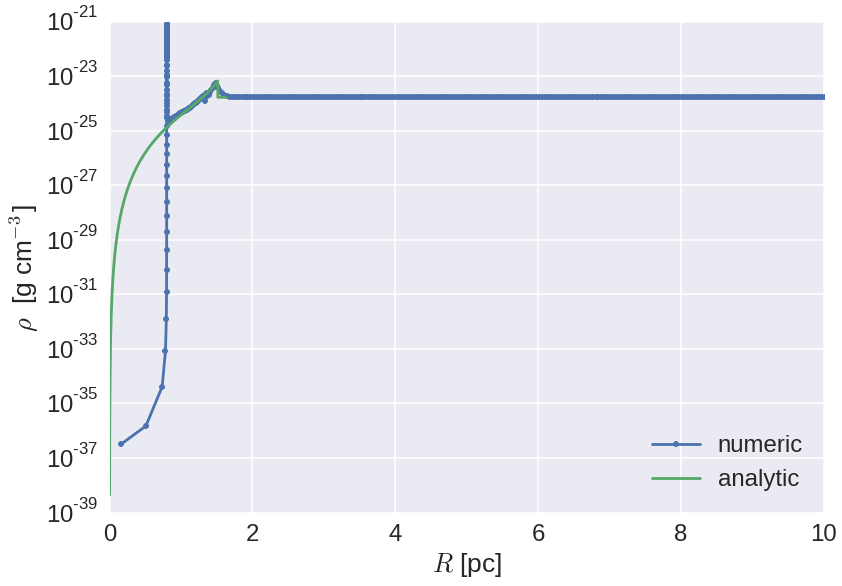

In [25]:


label_dict = {"R":"$R$ [pc]", 
              "U": r"$U$ [cm s$^{-1}$]",
              "rho": r"$\rho$  [g cm$^{-3}$]",
              "T": r"$T$ [K]",
              "Mass" : r"$M$ [$M_\odot$]",
              "C_ad": r"$C_{ad}$ [cm s$^{-1}$]",
              "E": r"$E_{int}$ [erg g$^{-1}$]",
              "P": r"$P$ [dyne cm$^{-2}$]",
              "Q": r"$Q$ [dyne cm$^{-2}$]",
              "S": r"$S$ [$k_b$ / particle]",
              "M_int": r"$M_{int}$ [$M_\odot$]"
             }

zones_or_edges = {"R"     : edges, 
                  "U"     : edges,
                  "rho"   : zones,
                  "T"     : zones,
                  "Mass"  : zones,
                  "C_ad"  : zones,
                  "E"     : zones,
                  "P"     : zones,
                  "Q"     : zones,
                  "S"     : zones,
             }


def plot_var(var="rho", R_as_x=True, with_sedov=True, k=0):
    print("current time: " + str(df_info.iloc[k].time_total / yr) + " yr")
    print("energy conserved to: ", (df_info.iloc[k].E_tot / df_info.iloc[0].E_tot) - 1)
    
    marker="."
    
    if with_sedov is True:
        sedov = dimensionalize_sedov.main(df_info.iloc[k].time_total)
        sedov = np.array(sedov).transpose()
        df_sedov = pd.DataFrame.from_records(sedov, columns=["R", "U", "rho", "T", "C_ad", "E", "P", "S", "Mass"])
        df_sedov.R /= pc
        df_sedov.Mass /= M_solar
        df_sedov.set_index(['R'], inplace=True)
        df_sedov["M_int"] = df_sedov.Mass.cumsum()
    
    df = zones_or_edges[var]
    if R_as_x is True:
        df[df.k==ks[k]][var].plot(label="numeric", marker=marker)
    else:
        plt.plot(M_int, df[df.k==ks[k]][var],label="numeric",marker=marker)
        plt.xlabel(label_dict["M_int"])
        plt.xscale("log")
    
    if with_sedov is True and ((var!="Q") and (var is not "Mass")):
        if R_as_x is True:
            df_sedov[var].plot(label="analytic")
        else:
            plt.plot(df_sedov.M_int, df_sedov[var], label="analytic")
    plt.xlabel(label_dict["R"])
    plt.ylabel(label_dict[var])
    plt.yscale("log")
    plt.legend(loc="lower right")
    plt.xlim((0,10))


    
interact(plot_var,
         var=variables_velos,
         R_as_x = True,
         with_sedov = True,
         k=(0,len(ks)-1))







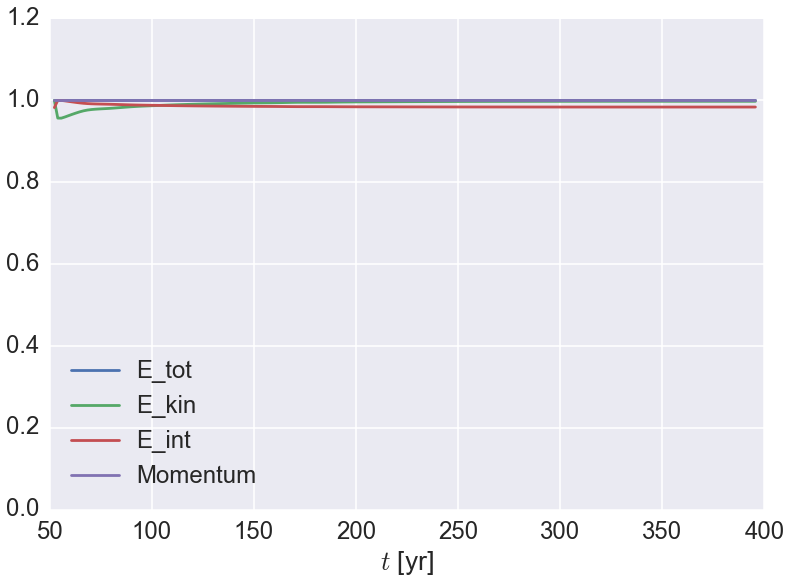

In [49]:
plt.figure()
plt.plot(df_info.time_total/ yr, df_info.E_tot / df_info.E_tot.max(), label="E_tot")
plt.plot(df_info.time_total/ yr, df_info.E_kin / df_info.E_kin.max(), label="E_kin")
plt.plot(df_info.time_total/ yr, df_info.E_int / df_info.E_int.max(), label="E_int")
plt.plot(df_info.time_total/ yr, df_info.Momentum / df_info.Momentum.max(), label="Momentum")
plt.xlabel(r"$t$ [yr]")
plt.ylim((0,1.2))
plt.legend(loc="best")

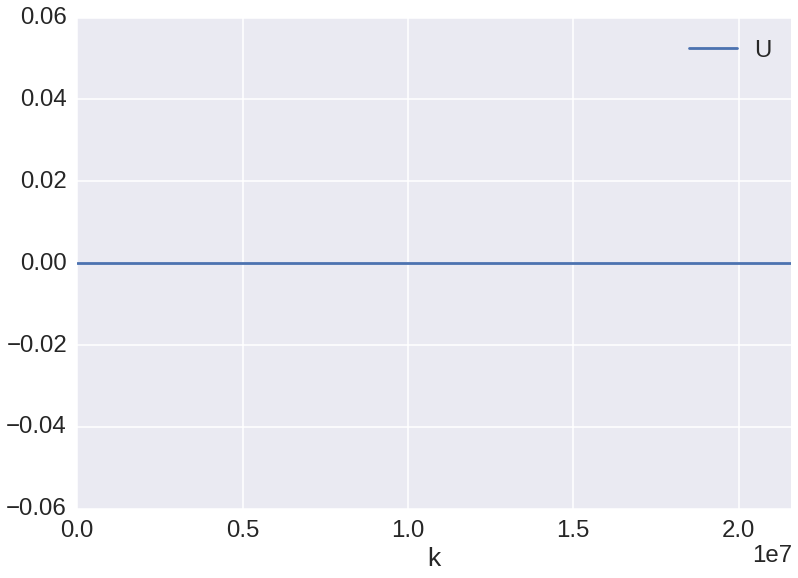

In [12]:

df_velos.loc[1].set_index(["k"]).U.plot()
plt.legend(loc="best")